# Prophet Model: Build, Save, and Inference Example


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load data
df = pd.read_csv("cashflow_user_2024_balanced.csv")
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Ambil saldo harian (asumsi: 'total' adalah saldo terakhir harian)
daily = df.groupby('transaction_date')['total'].last().reset_index()
daily = daily.sort_values('transaction_date')
daily.set_index('transaction_date', inplace=True)

# Pastikan frekuensi harian dan isi missing value
daily = daily.asfreq('D')
daily['total'] = daily['total'].ffill()


In [ ]:
scaler = MinMaxScaler()
scaled_total = scaler.fit_transform(daily[['total']])


In [ ]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 90
X, y = create_sequences(scaled_total, window_size)

# Bentuk untuk LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))


In [ ]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])


model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model.fit(X, y, epochs=50, batch_size=32, verbose=1, callbacks=[early_stop])


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.3049
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0338
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0148
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0060
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0041
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0042
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0036
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0031
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0027
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0027
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0026
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0025
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0024
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0023
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0024
Epoch 16/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms

In [ ]:
# Prediksi 365 hari ke depan
n_future = 365
last_input = scaled_total[-window_size:].reshape(1, window_size, 1)
preds = []

for _ in range(n_future):
    pred = model.predict(last_input, verbose=0)[0][0]
    preds.append(pred)
    last_input = np.append(last_input[:, 1:, :], [[[pred]]], axis=1)

# Rescale ke nilai asli
preds_rescaled = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# Buat tanggal prediksi
future_dates = pd.date_range(start=daily.index[-1] + pd.Timedelta(days=1), periods=n_future)

# Gabungkan jadi DataFrame
forecast_df = pd.DataFrame({'date': future_dates, 'predicted_total': preds_rescaled.flatten()})


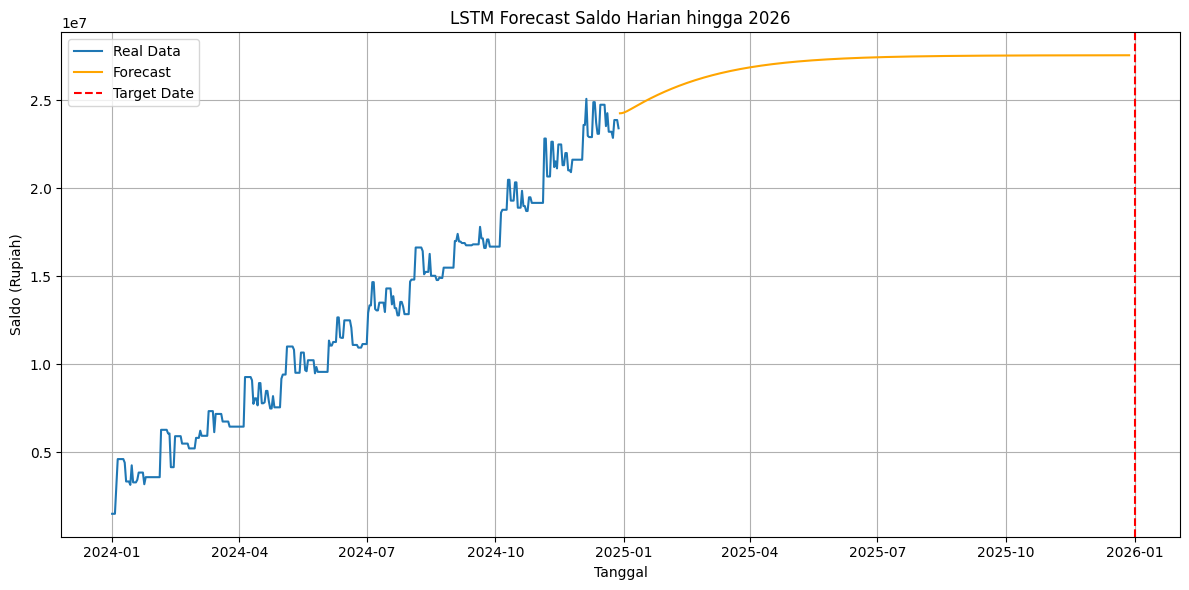

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(daily.index, daily['total'], label='Real Data')
plt.plot(forecast_df['date'], forecast_df['predicted_total'], label='Forecast', color='orange')
plt.axvline(pd.to_datetime("2026-01-01"), color='red', linestyle='--', label='Target Date')
plt.title("LSTM Forecast Saldo Harian hingga 2026")
plt.xlabel("Tanggal")
plt.ylabel("Saldo (Rupiah)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
